In [389]:
#Define antenna numbers 
antenna1 = 36
antenna2 = 37


In [390]:
#Initialize matplotlib notebook
%matplotlib notebook
#Import needed packages
from pyuvdata import UVData
import numpy as np
import glob
import matplotlib.pyplot as plt
from matplotlib.colors import SymLogNorm
import cmath

#Create uv elements
uvxy = UVData()
uvyx = UVData()
uvxx = UVData()
uvyy = UVData()

#Create constant variables
#Variable for the speed of light
c = 3e8 #2.99792 * 1e8
#Variable for speed of light in a cable correction factor, based on Google search
f = .83

#Create an array of antennas we want to flag
flagged_antennas = np.array([0,2,26,50,84,98,136])


# Read in the xy data file
uvxy.read_uvfits('/data6/HERA/data/IDR2.1/uvOCRSL_crosspol_time_split/xy_time_split_data/combined_files/zen.grp1.of1.xy.LST.run_7.uvOCRSL.uvfits', antenna_nums=(antenna1,antenna2))

#Read in the position and antenna numbers for all antennas
antpos, ants = uvxy.get_ENU_antpos()

print uvxy.uvw_array

tau_a = np.sqrt(uvxy.uvw_array[1,0]**2 + uvxy.uvw_array[1,1]**2 + uvxy.uvw_array[1,2]**2) 
print tau_a, '(m)'
#tau_a = tau_a / c
#print tau_a, '(ns)'

#Create a dictionary which associates the antenna number with the indexing number in ants
ant_dict = {x: i for i,x in enumerate(uvxy.antenna_numbers)}

[[ 0.          0.          0.        ]
 [14.607312    0.08500197  0.13943665]
 [ 0.          0.          0.        ]]
14.608225001453711 (m)


In [391]:
#Define frequency variable
nu = uvxy.freq_array
print nu.shape
#Nu is in Hz, or 1/seconds

if antenna1>antenna2:
    const = np.pi * (1j) * 2 * tau_a / c
else: 
    const = np.pi * (-1j) * 2 * tau_a / c
expo =  nu * const

#Form baseline dependent exponential
e_a = np.e**(expo)
print e_a.shape
print np.mean(e_a)

print np.argwhere(e_a==np.max(e_a))

(1, 1024)
(1, 1024)
(-0.008327044488836255-0.024708286142574212j)
[[  0 448]]


In [392]:
# 1) Fourier transform "vis_avg" along the freq axis
vis_avg_delay_xy = np.fft.fftshift(np.fft.fft(e_a,axis=1))
vis_avg_delay_xy = np.mean(vis_avg_delay_xy,axis=0)
print vis_avg_delay_xy.shape
print np.max(vis_avg_delay_xy)

# 2) Find the frequency width of a channel in GHz
freq_width_xy = np.diff(nu[0,:])[0]
print freq_width_xy

# 3) Convert frequencies to delays and convert to ns. Numpy's fftfreq function takes two arguments:
#    the number of frequencies, and the frequency width you calculated above
delays_xy = np.fft.fftshift(np.fft.fftfreq(uvxy.Nfreqs,freq_width_xy))*1e9
print delays_xy.shape

model_max = np.max(np.abs(vis_avg_delay_xy))
print model_max
print np.argwhere(np.abs(vis_avg_delay_xy)==model_max)
print delays_xy[np.argwhere(np.abs(vis_avg_delay_xy)==model_max)]

(1024,)
(332.3661817088344+938.3932636977836j)
97656.25
(1024,)
995.5145383655067
[[507]]
[[-50.]]


In [393]:
# 1) Fourier transform "vis_avg" along the freq axis
vis_t = np.mean(uvxy.get_data(antenna1,antenna2),axis=0)
print vis_t.shape

vis_avg_delay_t = np.fft.fftshift(np.fft.fft(vis_t))
print vis_avg_delay_t.shape

# 2) Find the frequency width of a channel in GHz
freq_width_t = np.diff(uvxy.freq_array[0,:])[0]
print freq_width_t

# 3) Convert frequencies to delays and convert to ns. Numpy's fftfreq function takes two arguments:
#    the number of frequencies, and the frequency width you calculated above
delays_t = np.fft.fftshift(np.fft.fftfreq(uvxy.Nfreqs,freq_width_t)*1e9)
print np.mean(delays_t)
print delays_t


real_abs_max = np.max(np.abs(vis_avg_delay_t))
print real_abs_max
print np.argwhere(np.abs(vis_avg_delay_t)==real_abs_max)
print delays_t[np.argwhere(np.abs(vis_avg_delay_t)==real_abs_max)]

(1024,)
(1024,)
97656.25
-5.0
[-5120. -5110. -5100. ...  5090.  5100.  5110.]
161.59402
[[506]]
[[-60.]]


Antenna 36 and 37


<IPython.core.display.Javascript object>


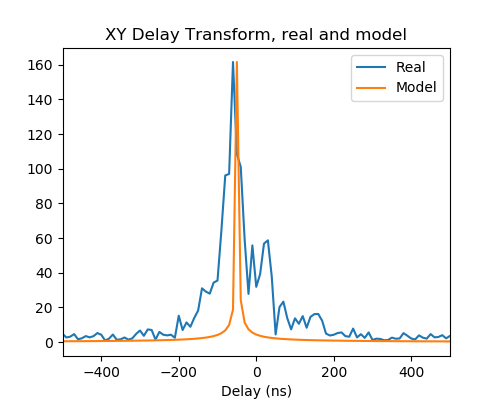

Text(0.5,1,'XY Delay Transform, real and model')

In [394]:
#Plot
amp_factor = model_max / real_abs_max
print 'Antenna', antenna1, 'and', antenna2

plt.figure(figsize=(5,4))

plt.plot((delays_t),np.abs(vis_avg_delay_t), label='Real')
plt.plot((delays_xy),np.abs(vis_avg_delay_xy)/amp_factor, label='Model')
plt.xlabel('Delay (ns)')
plt.xlim(-500,500) # zoom-in
plt.legend()
plt.title('XY Delay Transform, real and model')

In [395]:
max_peak = 0
mod_delay = []
con_delays = []
vis_avg = []
for i,ant1 in enumerate(uvxy.ant_2_array):
    ant2 = uvxy.ant_1_array[i]
    
    if (ant1==antenna1 and ant2==antenna2) or (ant1==antenna2 and ant2==antenna1):
        spectrum = uvxy.data_array[i,0,:,0]
        vis_avg = np.fft.fftshift(np.fft.fft(spectrum))
        freq_width = np.diff(uvxy.freq_array[0,:])[0]
        con_delays = np.fft.fftshift(np.fft.fftfreq(uvxy.Nfreqs,freq_width))*1e9
        max_peak = np.max(np.abs(vis_avg))
        corr_delay = con_delays[np.argwhere(np.abs(vis_avg)==max_peak)]
        mod_delay.append(corr_delay)

#print vis_avg.shape
tau_test = np.mean(mod_delay) / 1e9
#print tau_test * 1e9

if antenna1>antenna2:
    e_test = np.e**((-1j) * np.pi * 2 * nu * tau_test)
else:
    e_test = np.e**((1j) * np.pi * 2 * nu * tau_test)
#print e_test.shape

# 1) Fourier transform "vis_avg" along the freq axis
vis_avg_test = np.mean(e_test,axis=0)
vis_avg_test = np.fft.fftshift(np.fft.fft(vis_avg_test))

#print vis_avg_test.shape
#print np.max(vis_avg_test)


model_test = np.max(np.abs(vis_avg_test))
#print model_test
print np.argwhere(np.abs(vis_avg_test)==model_test)
print con_delays[np.argwhere(np.abs(vis_avg_test).real==model_test)]


[[506]]
[[-60.]]


Antenna 36 and 37


<IPython.core.display.Javascript object>


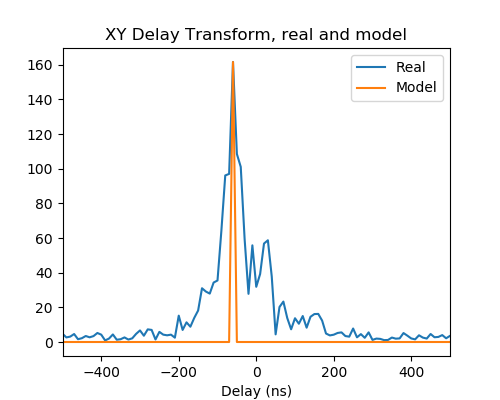

Text(0.5,1,'XY Delay Transform, real and model')

In [397]:
amp_factor2 = model_test / real_abs_max
print 'Antenna', antenna1, 'and', antenna2

plt.figure(figsize=(5,4))

plt.plot((delays_t),np.abs(vis_avg_delay_t), label='Real')
plt.plot((con_delays),np.abs(vis_avg_test)/amp_factor2, label='Model')
plt.xlabel('Delay (ns)')
plt.xlim(-500,500) # zoom-in
plt.legend()
plt.title('XY Delay Transform, real and model')